# Processamento de Imagens Digitais 
## Dept. de Estatística, Mat. Aplicada e Computação (DEMAC)
#### Prof. Dr. Daniel Carlos Guimarães Pedronette

Relatório da lista de exercícios N° 1
-------------------------------
**Nome:** Álvaro Leandro Cavalcante Carneiro 


**Linguagem utilizada:** Python 3.6



## Importando as bibliotecas 
Importando as bibliotecas que serão utilizadas para desenvolver as atividades.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import data
import cv2

## Carregamento das imagens
As imagens utilizadas serão carregadas da biblioteca *SkImage* [https://scikit-image.org/docs/dev/api/skimage.data.html], assim como foi nas outras listas de exercícios. Igualmente, as imagens RGB serão convertidas para escala de cinza no método *convert_to_gray* para fins de simplicidade.

In [35]:
def convert_to_gray(image, luma=False):
    if luma:
        params = [0.299, 0.589, 0.114]
    else:
        params = [0.2125, 0.7154, 0.0721]

    gray_image = np.ceil(np.dot(image[...,:3], params))
    gray_image[gray_image > 255] = 255
    
    return gray_image.astype('uint8')

Foram escolhidas duas imagens para segmentação, uma delas (da astrounauta), possui uma quantidade maior de detalhes e portanto representa um desafio maior para segmentação, enquanto a outra (parede de blocos) é mais simples e possuir bordas mais claras.

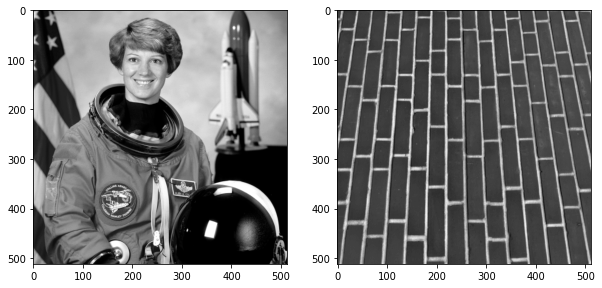

In [36]:
image = convert_to_gray(data.astronaut())
image2 = data.brick()
figure, axarr = plt.subplots(1,2, figsize=(10, 10))
axarr[0].imshow(image, cmap='gray')
axarr[1].imshow(image2, cmap='gray')

## Filtragem espacial por convolução
A convolução foi utilizada para a aplicação dos filtros de segmentação das imagens. Sendo assim, o método de convolução criado no exercício anterior foi reaproveitado.

In [4]:
def get_img_with_padding(image, kernel):
    hor_stack = 0
    while ((kernel.shape[0] - 1) - hor_stack) != 0:  # preenche as linhas da matriz
        image = np.insert(image, 0, 0, axis=0)
        image = np.vstack([image, np.zeros(image.shape[1])])
        hor_stack += 1
        
    vert_stack = 0
    while ((kernel.shape[0] - 1) - vert_stack) != 0: # preenche as colunas
        image = np.insert(image, 0, 0, axis=1)
        image = np.hstack([image, np.zeros((image.shape[0], 1))])
        vert_stack += 1
        
    return image

In [5]:
def convolution(image, kernel, stride, function=False, padding=False):
    initial_line = 0
    final_line = kernel.shape[0]
    new_image = []

    if padding:
        image = get_img_with_padding(image, kernel)
    
    while final_line <= image.shape[0]: # percorrendo pelas linhas    
        initial_column = 0
        final_column = kernel.shape[1]
        matrix_line = []

        while final_column <= image.shape[1]: # percorrendo pelas colunas
            # área da imagem que será multiplicada pelo kernel
            kernel_area = image[initial_line:final_line, initial_column:final_column]
            
            # esse IF define se será aplicado uma função personalizada ou uma simples multiplicação matricial
            if function:
                matrix_line.append(function(kernel_area))
            else:
                matrix_line.append(np.sum(kernel * kernel_area))
        
            initial_column += stride # quantidade de linhas a serem puladas 
            final_column += stride
        
        new_image.append(matrix_line) 
        final_line += 1
        initial_line += 1

    return np.asmatrix(new_image)

## Definindo os kernels para segmentação
Os kernels utilizados na segmentação das imagens foram definidos abaixo, sendo eles o filtro de Sobel, Prewitt e roberts. As duas variantes foram testandas, tanto as de eixo Y como de eixo X (em relação a forma de destacar as bordas).

In [6]:
sobel_y = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
sobel_x = np.array([[-1,-2,-1],[0, 0, 0],[1, 2, 1]])

prewitt_x = np.array([[-1,-1,-1], [0,0,0], [1,1,1]])
prewitt_y = np.array([[-1,0,1], [-1,0,1], [-1,0,1]])

roberts_1 = np.array([[1,0], [0,-1]])
roberts_2 = np.array([[0,-1], [1,0]])

### Filtro de Sobel

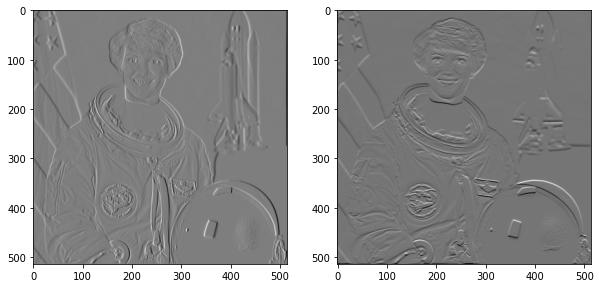

In [7]:
conv_image1 = convolution(image.copy(), sobel_y, 1, padding=True)
conv_image2 = convolution(image.copy(), sobel_x, 1, padding=True)

figure, axarr = plt.subplots(1,2, figsize=(10, 10))
axarr[0].imshow(conv_image1, cmap='gray')
axarr[1].imshow(conv_image2, cmap='gray')

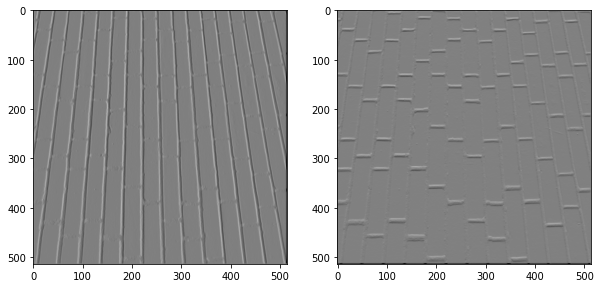

In [8]:
conv_image1 = convolution(image2.copy(), sobel_y, 1, padding=True)
conv_image2 = convolution(image2.copy(), sobel_x, 1, padding=True)

figure, axarr = plt.subplots(1,2, figsize=(10, 10))
axarr[0].imshow(conv_image1, cmap='gray')
axarr[1].imshow(conv_image2, cmap='gray')

A aplicação do filtro de Sobel traz efeitos interessantes na imagem, possuindo diferenças aparentes em relação a sua aplicação horizontal e verical. Essa diferença é bastante destacada na parede de blocos, onde a primeira imagem (com destaque vertical) se parece com um conjunto de linhas retas, enquanto a segunda já traz a aparência mais similar a imagem original. Portanto, a orientação do filtro de segmentação de bordas é uma importante escolha baseada no objetivo que se quer atingir. 

Apenas para fins de curiosidade, foi comparado a técnica de filtragem de Sobel desenvolvida aqui (imagem a esquerda) e a implementação da biblioteca OpenCV (imagem a direita). É possível reparar que as imagens são idênticas, validando os resultados obtidos.

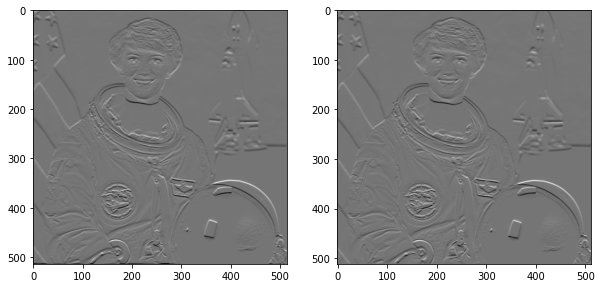

In [50]:
sobelx = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=3)
conv_image = convolution(image.copy(), sobel_x, 1, padding=True)

figure, axarr = plt.subplots(1,2, figsize=(10, 10))
axarr[0].imshow(conv_image, cmap='gray')
axarr[1].imshow(sobelx, cmap='gray')

### Filtro de Prewitt

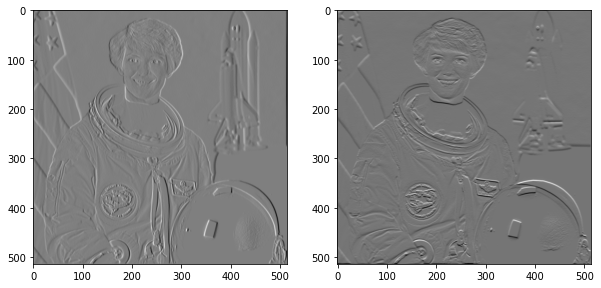

In [39]:
conv_image1 = convolution(image.copy(), prewitt_y, 1, padding=True)
conv_image2 = convolution(image.copy(), prewitt_x, 1, padding=True)

figure, axarr = plt.subplots(1,2, figsize=(10, 10))
axarr[0].imshow(conv_image1, cmap='gray')
axarr[1].imshow(conv_image2, cmap='gray')

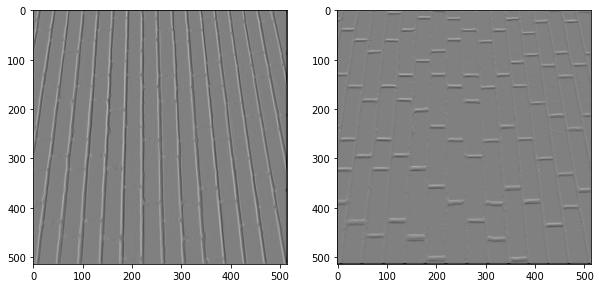

In [40]:
conv_image1 = convolution(image2.copy(), prewitt_y, 1, padding=True)
conv_image2 = convolution(image2.copy(), prewitt_x, 1, padding=True)

figure, axarr = plt.subplots(1,2, figsize=(10, 10))
axarr[0].imshow(conv_image1, cmap='gray')
axarr[1].imshow(conv_image2, cmap='gray')

O efeito alcançado pelo filtro de Prewitt foi bastante similar ao de Sobel, sendo nesses casos consideradas imperceptíveis.

### Filtro de Roberts

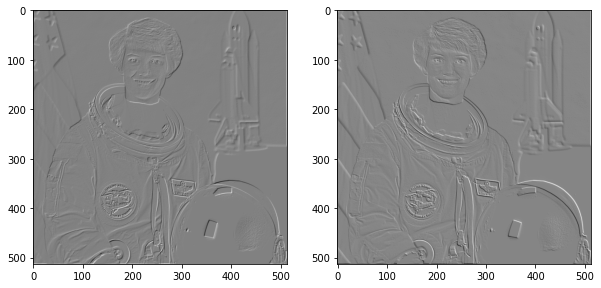

In [42]:
conv_image1 = convolution(image.copy(), roberts_1, 1, padding=True)
conv_image2 = convolution(image.copy(), roberts_2, 1, padding=True)

figure, axarr = plt.subplots(1,2, figsize=(10, 10))
axarr[0].imshow(conv_image1, cmap='gray')
axarr[1].imshow(conv_image2, cmap='gray')

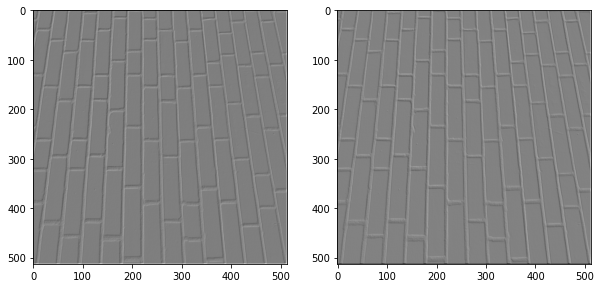

In [12]:
conv_image1 = convolution(image2.copy(), roberts_1, 1, padding=True)
conv_image2 = convolution(image2.copy(), roberts_2, 1, padding=True)

figure, axarr = plt.subplots(1,2, figsize=(10, 10))
axarr[0].imshow(conv_image1, cmap='gray')
axarr[1].imshow(conv_image2, cmap='gray')

A principal diferença percebina no filtro de Roberts foi a diminuição no efeito do destaque vertical/horizontal, conforme é possível verificar na imagem da parede de blocos, onde as linhas verticais e horizontais estão mais balanceadas na imagem.

## Aplicação do Laplaciano
O próximo passo é a aplicação do filtro Laplaciano, definido abaixo nas duas variações mostradas no slide, com valores ponderados menores e maiores respectivamente.

In [13]:
laplacian = np.array([[0,-1,0], [-1,4,-1], [0,-1,0]])
laplacian2 = np.array([[-1,-4,-1], [-4,20,-4], [-1,-4,-1]])

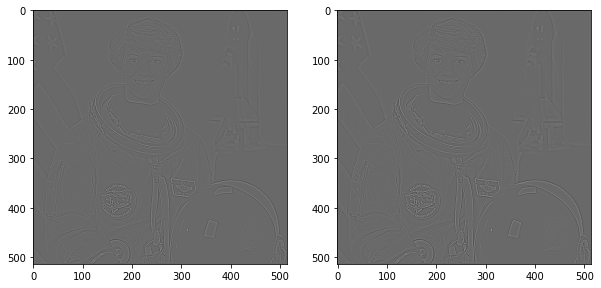

In [14]:
conv_image1 = convolution(image.copy(), laplacian, 1, padding=True)
conv_image2 = convolution(image.copy(), laplacian2, 1, padding=True)

figure, axarr = plt.subplots(1,2, figsize=(10, 10))
axarr[0].imshow(conv_image1, cmap='gray')
axarr[1].imshow(conv_image2, cmap='gray')

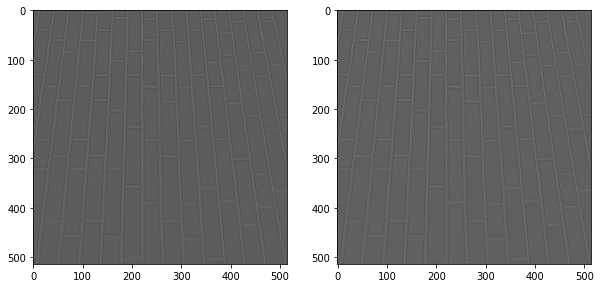

In [15]:
conv_image1 = convolution(image2.copy(), laplacian, 1, padding=True)
conv_image2 = convolution(image2.copy(), laplacian2, 1, padding=True)

figure, axarr = plt.subplots(1,2, figsize=(10, 10))
axarr[0].imshow(conv_image1, cmap='gray')
axarr[1].imshow(conv_image2, cmap='gray')

Nesse caso, o operador Laplaciano não atuou com sucesso na detecção de bordas, mesclando muito os detalhes da imagem e deixando um baixo destaque das bordas. Outros dois testes realizados foram com o Lapaciano Gaussiano e com a aplicação do filtro da média, como tentativa de remover os ruídos e melhorar a detecção de bordas.

In [16]:
laplaciano_gau = np.array([[0,0,-1,0,0], [0,-1,-2,-1,0], [-1,-2,16,-2,-1], [0,-1,-2,-1,0], [0,0,-1,0,0]])
mean = np.full((5,5), 0.11111111111)

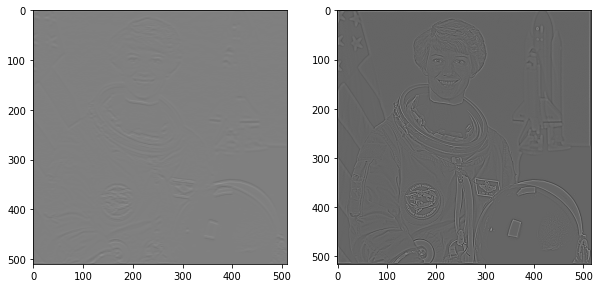

In [18]:
cv1 = convolution(image.copy(), mean, 1)
conv_image1 = convolution(cv1, laplacian, 1, padding=True)
conv_image2 = convolution(image.copy(), laplaciano_gau, 1, padding=True)

figure, axarr = plt.subplots(1,2, figsize=(10, 10))
axarr[0].imshow(conv_image1, cmap='gray')
axarr[1].imshow(conv_image2, cmap='gray')

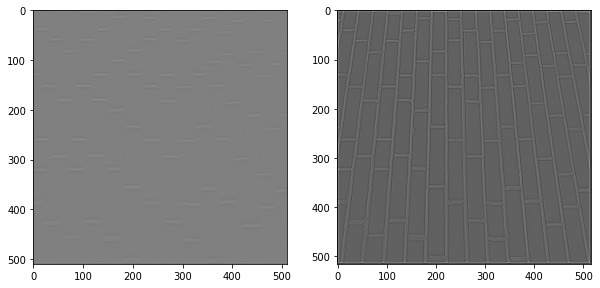

In [19]:
cv1 = convolution(image2.copy(), mean, 1)
conv_image1 = convolution(cv1, laplacian, 1, padding=True)
conv_image2 = convolution(image2.copy(), laplaciano_gau, 1, padding=True)

figure, axarr = plt.subplots(1,2, figsize=(10, 10))
axarr[0].imshow(conv_image1, cmap='gray')
axarr[1].imshow(conv_image2, cmap='gray')

Ambas técnicas, utilizando a filtragem pela média e depois a Laplaciana (imagem a esquerda) ou utilizando o Laplaciano Gaussiano (a direita) não foram bem sucedidas, onde uma removeu os detalhes em excesso, deixando-a mais próxima a um borrão homogêneo, enquanto outra presenvou alguns detalhes da imagem mas sem destaque especial para as bordas.

## Limiarização global
O método *binarize_img* foi criado para realizar a binarização na imagem de entrada, baseado em um limiar.

In [20]:
def binarize_img(img, threshold):
    img[img < threshold] = 0
    img[img >= threshold] = 1
    return img

Para testar a binarização utilizando diferentes limiares, foi criado o método *bin_test*, onde a ideia é gerar uma iteração e ir modificando o limiar de forma gradativa iniciando em 80 e indo até 180, para auxiliar na escolha do melhor valor.

In [26]:
def bin_test(image, min_threshold, max_threshold):
    threshold = min_threshold
    bin_image = []

    while threshold < max_threshold:
        bin_image.append(binarize_img(image.copy(), threshold))
        threshold += 20
        
    return bin_image

In [30]:
bin_image = bin_test(image.copy(), 80, 160)
bin_image2 = bin_test(image2.copy(), 80, 160)

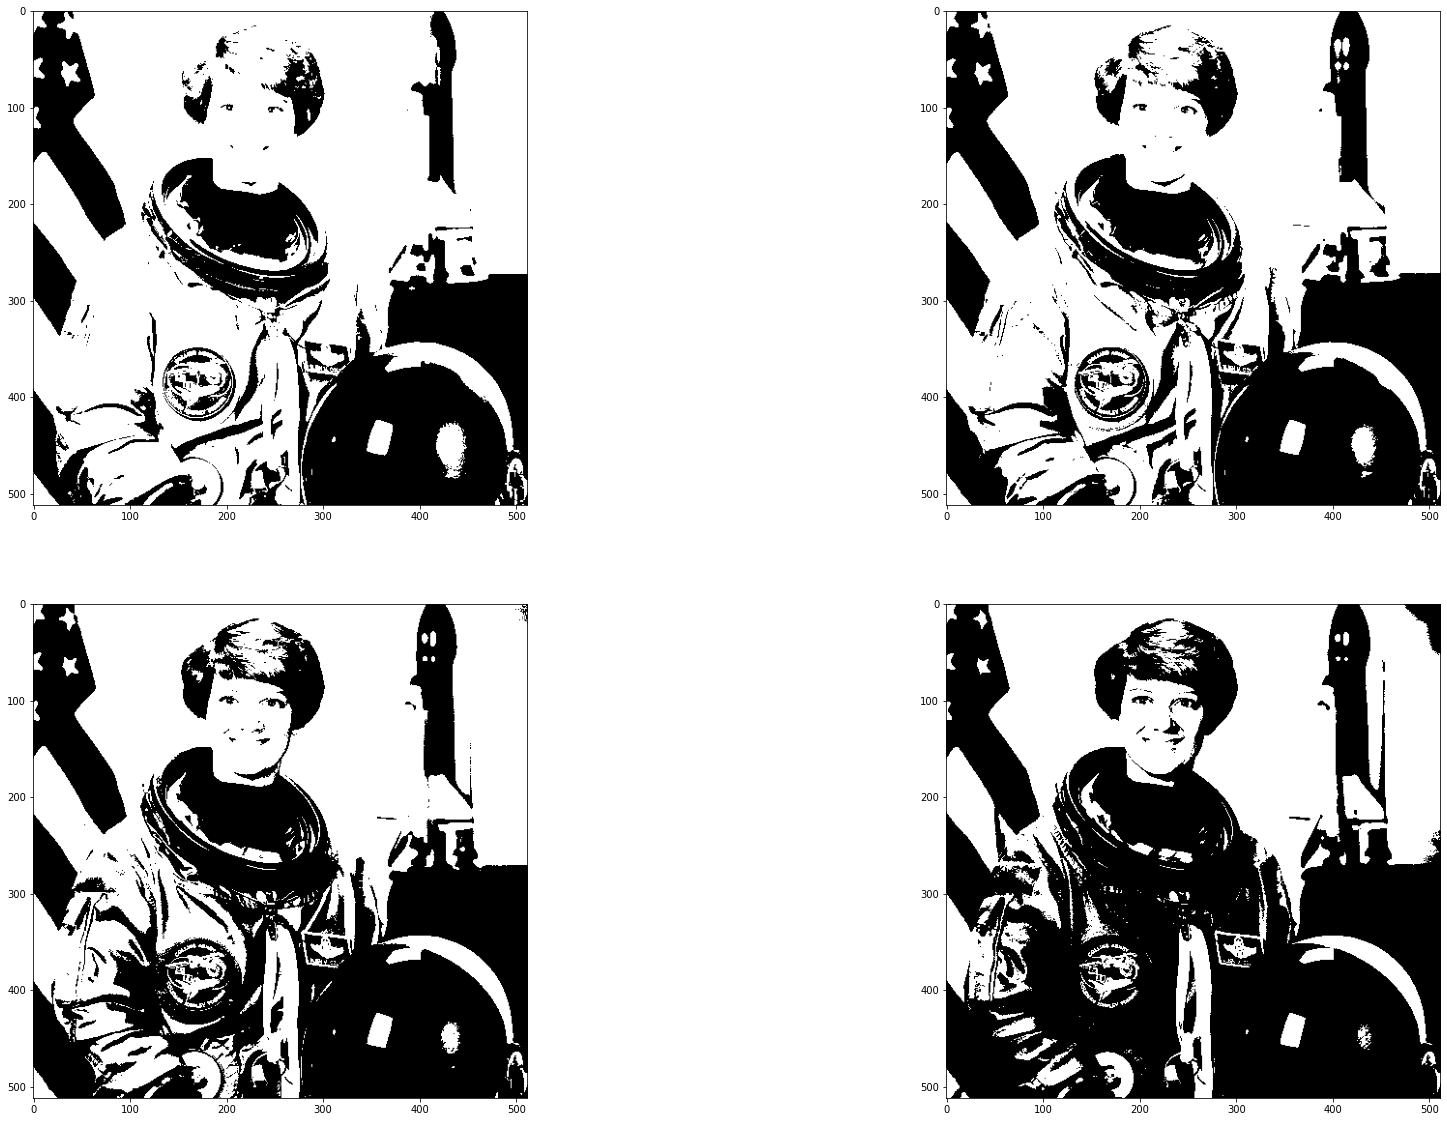

In [28]:
figure, axarr = plt.subplots(2,2, figsize=(30, 20))
axarr[(0, 0)].imshow(bin_image[0], cmap='gray')
axarr[(0 ,1)].imshow(bin_image[1], cmap='gray')
axarr[(1, 0)].imshow(bin_image[2], cmap='gray')
axarr[(1, 1)].imshow(bin_image[3], cmap='gray')

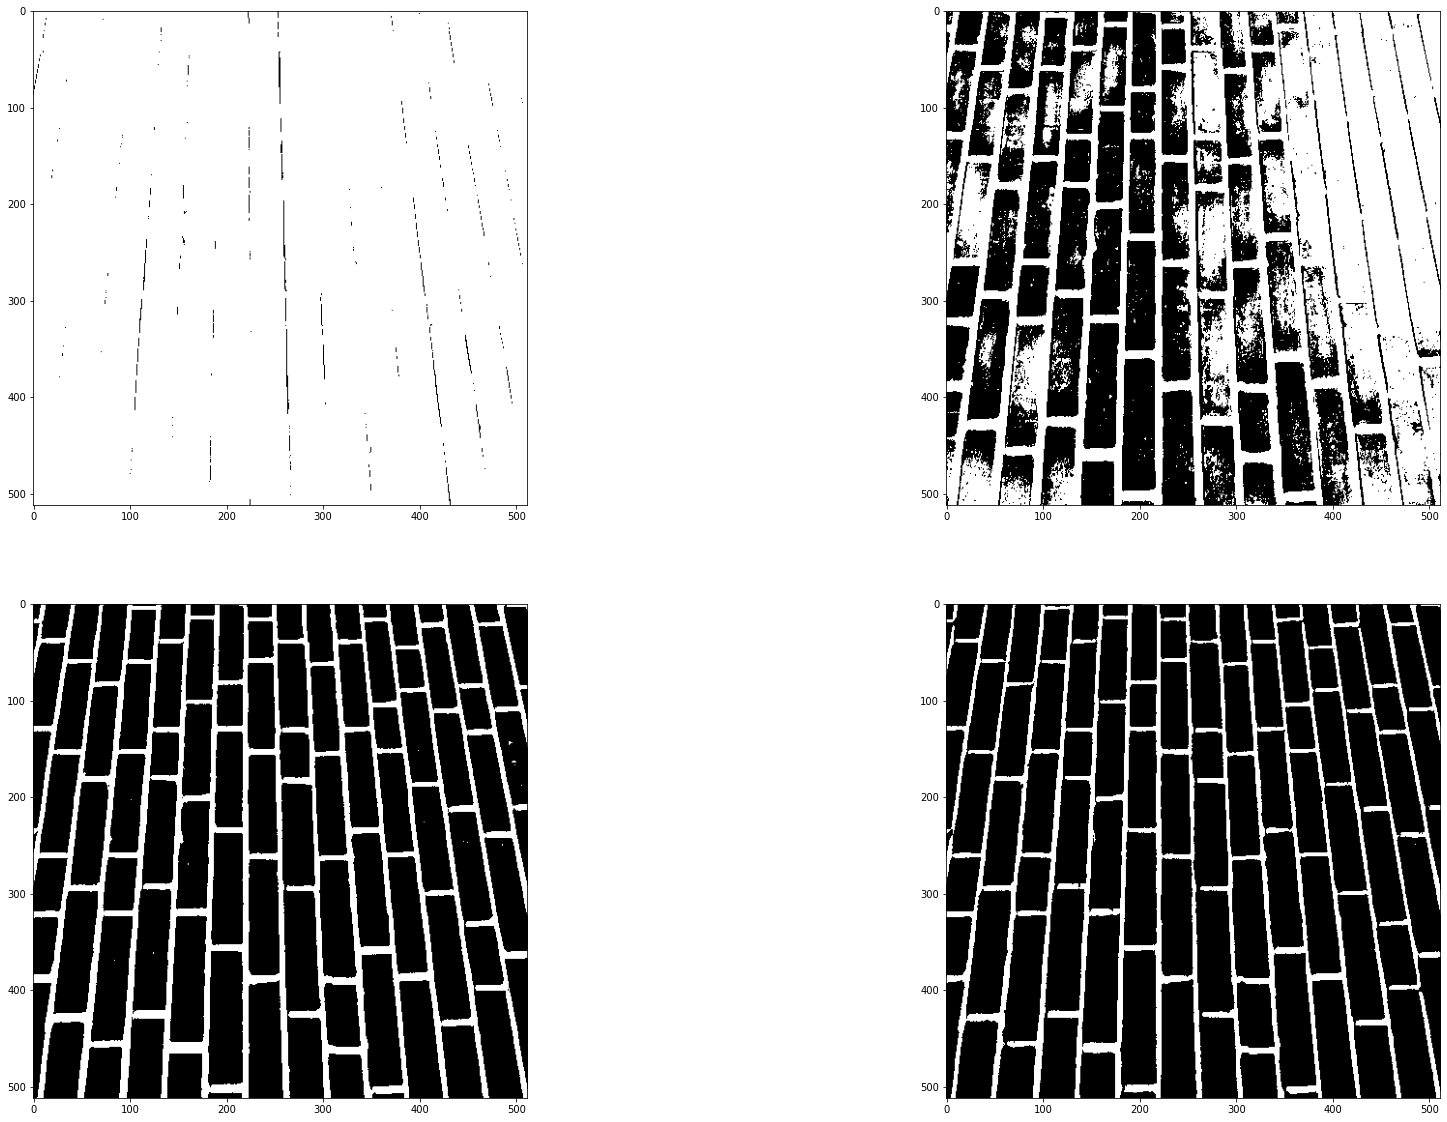

In [31]:
figure, axarr = plt.subplots(2,2, figsize=(30, 20))
axarr[(0, 0)].imshow(bin_image2[0], cmap='gray')
axarr[(0 ,1)].imshow(bin_image2[1], cmap='gray')
axarr[(1, 0)].imshow(bin_image2[2], cmap='gray')
axarr[(1, 1)].imshow(bin_image2[3], cmap='gray')

Um efeito visual interessante foi alcançado com um limiar mais alto, entre 120 e 140.

## Limiarização Otsu
A limiarização pelo método de Otsu foi implementada com o auxilio da biblioteca OpenCV, seu resultado pode ser visualizado abaixo.

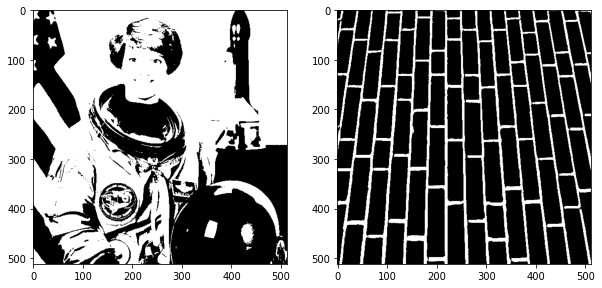

In [38]:
ret,th = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret2,th2 = cv2.threshold(image2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

figure, axarr = plt.subplots(1,2, figsize=(10, 10))
axarr[0].imshow(th, cmap='gray')
axarr[1].imshow(th2, cmap='gray')

O método de Otsu também chegou a bons resultados, embora algo similar seja possível com a tentativa e erro (conforme visto acima). Ainda assim, é um método eficiente pois consegue determinar um bom limiar de forma mais eficiente do que uma simples tentativa e erro aleatorizada. 